<a href="https://colab.research.google.com/github/Madou10-lab/image-classification-using-deep-learning/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


In [ ]:
from keras.utils import np_utils

we will import the cifar10 dataset , which have the images for our model to train on

In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [ ]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

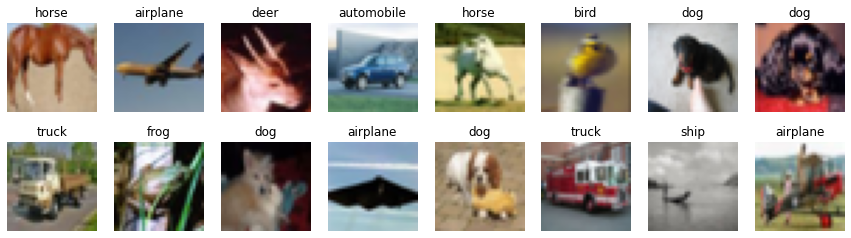

In [ ]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

**Prepare data**
We need to normalize inputs like this:
xnorm=x/255−0.5
xnorm=x/255−0.5

We need to convert class labels to one-hot encoded vectors

In [ ]:
x_train2 = (x_train/255) - 0.5
x_test2 = (x_test/255) - 0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = np_utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = np_utils.to_categorical(y_test, NUM_CLASSES)

In [ ]:
# import necessary building blocks
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

Define ***CNN architecture***

In [ ]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(layers.Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES))
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.Activation('softmax'))
    
    return model

In [ ]:
#Destroys the current TF graph and creates a new one. Useful to avoid clutter from old models / layers
keras.backend.clear_session()

In [ ]:
# describe model
model = make_model()

In [ ]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

We need to keep a check on the loss and accuracy of our MLP with CNN so that we can be sure that our defined MLP with CNN is working good and going towards minima.
This can be done using **tensorboard**, to access tensorboard from the colab environment you can use a service called as **ngrok**

In [ ]:
import time
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log/cnn', histogram_freq=1,
                         write_graph=True,
                         write_images=True)

In [ ]:
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    callbacks =[keras.callbacks.LearningRateScheduler(lr_scheduler),
                 LrHistory(),tbCallBack],
    initial_epoch= 0
)

Learning rate: 0.005
Learning rate: 0.0045
Learning rate: 0.00405
Learning rate: 0.003645
Learning rate: 0.0032805
Learning rate: 0.00295245
Learning rate: 0.002657205
Learning rate: 0.0023914846
Learning rate: 0.002152336
Learning rate: 0.0019371024


**Evaluate model** time to test it

In [ ]:
# make test predictions
y_pred_test = model.predict(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

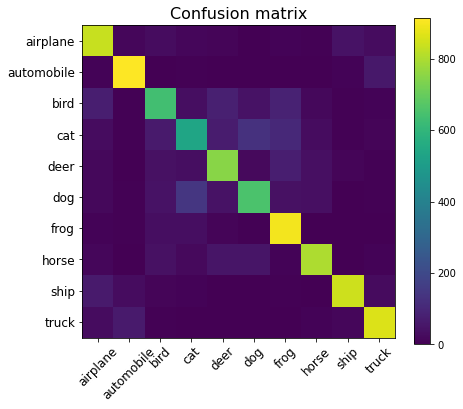

Test accuracy: 0.7741


In [ ]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

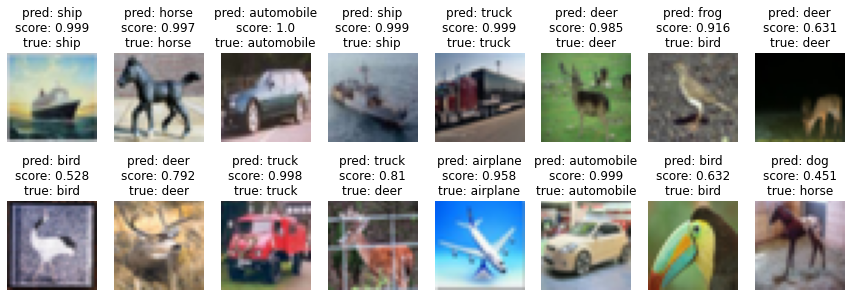

In [ ]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

In [ ]:
# Evaluating the Predictions on the Model
score = model.evaluate(x_test2, y_test2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6695656180381775
Test accuracy: 0.7741000056266785


**`Save the model in h5 format`** , An H5 file is a data file saved in the Hierarchical Data Format (HDF). It contains multidimensional arrays of scientific data

In [ ]:
# Save the model in h5 format 
model.save("model.h5")